In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vatsalgandhi01000111","key":"37c871096ebfaaeeddcbac2fd49416c5"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

 99% 1.16G/1.17G [00:09<00:00, 98.5MB/s]
100% 1.17G/1.17G [00:09<00:00, 139MB/s] 


In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
torch.__version__
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize(size = (256,256)),
    transforms.Grayscale(num_output_channels = 3),
    transforms.ToTensor()
    ])

In [ ]:
!unzip /content/labeled-chest-xray-images.zip -d /content/labeled-chest-xray-images

Streaming output truncated to the last 5000 lines.
  inflating: /content/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: /content/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: /content/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: /content/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: /content/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: /content/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: /content/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: /content/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: /content/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: /content/labeled-chest-xray-images/chest_xray/

In [ ]:
train_dir = '/content/labeled-chest-xray-images/chest_xray/train'
test_dir = '/content/labeled-chest-xray-images/chest_xray/test'

In [ ]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 5232
    Root location: /content/labeled-chest-xray-images/chest_xray/train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
               Grayscale(num_output_channels=3)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 624
    Root location: /content/labeled-chest-xray-images/chest_xray/test
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
               Grayscale(num_output_channels=3)
               ToTensor()
           )


In [ ]:
class_names = train_data.classes


# Can also get class names as a dict
class_dict = train_data.class_to_idx


# Check the lengths

len(train_data), len(test_data), class_names, class_dict

(5232, 624, ['NORMAL', 'PNEUMONIA'], {'NORMAL': 0, 'PNEUMONIA': 1})

In [ ]:
from torch.utils.data import DataLoader

BATCH = 32
WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH,
                              num_workers=WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH,
                             num_workers=WORKERS,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ee5efac7100>,
 <torch.utils.data.dataloader.DataLoader at 0x7ee5efac7880>)

In [ ]:
import torchvision.models as models

class VGG19Binary(nn.Module):
    def __init__(self):
        super(VGG19Binary, self).__init__()
        self.vgg19 = models.vgg19(weights=True)
        # Freeze all the layers in the VGG16 model
        for param in self.vgg19.parameters():
            param.requires_grad = False

        # Replace the last fully connected layer with a custom binary classifier
        num_features = self.vgg19.classifier[6].in_features
        self.vgg19.classifier[6] = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2),  # Binary classification - 2 output classes
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.vgg19(x)
model = VGG19Binary().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 173MB/s]


In [ ]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model, input_size=[1, 3, 256, 256])

Layer (type:depth-idx)                   Output Shape              Param #
VGG19Binary                              [1, 2]                    --
├─VGG: 1-1                               [1, 2]                    --
│    └─Sequential: 2-1                   [1, 512, 8, 8]            --
│    │    └─Conv2d: 3-1                  [1, 64, 256, 256]         (1,792)
│    │    └─ReLU: 3-2                    [1, 64, 256, 256]         --
│    │    └─Conv2d: 3-3                  [1, 64, 256, 256]         (36,928)
│    │    └─ReLU: 3-4                    [1, 64, 256, 256]         --
│    │    └─MaxPool2d: 3-5               [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-6                  [1, 128, 128, 128]        (73,856)
│    │    └─ReLU: 3-7                    [1, 128, 128, 128]        --
│    │    └─Conv2d: 3-8                  [1, 128, 128, 128]        (147,584)
│    │    └─ReLU: 3-9                    [1, 128, 128, 128]        --
│    │    └─MaxPool2d: 3-10              [1, 128, 64, 64]    

Epoch 1/10, Train Loss: 0.2825, Train Accuracy: 87.98%, Test Loss: 0.2523, Test Accuracy: 89.10%
Epoch 2/10, Train Loss: 0.2098, Train Accuracy: 91.82%, Test Loss: 0.2715, Test Accuracy: 88.46%
Epoch 3/10, Train Loss: 0.1915, Train Accuracy: 92.41%, Test Loss: 0.2590, Test Accuracy: 88.78%
Epoch 4/10, Train Loss: 0.1832, Train Accuracy: 93.04%, Test Loss: 0.2152, Test Accuracy: 90.87%
Epoch 5/10, Train Loss: 0.1868, Train Accuracy: 92.74%, Test Loss: 0.2482, Test Accuracy: 89.58%
Epoch 6/10, Train Loss: 0.1915, Train Accuracy: 92.01%, Test Loss: 0.2046, Test Accuracy: 91.83%
Epoch 7/10, Train Loss: 0.1860, Train Accuracy: 92.72%, Test Loss: 0.2469, Test Accuracy: 89.42%
Epoch 8/10, Train Loss: 0.1817, Train Accuracy: 93.00%, Test Loss: 0.2320, Test Accuracy: 90.06%
Epoch 9/10, Train Loss: 0.1808, Train Accuracy: 92.89%, Test Loss: 0.2520, Test Accuracy: 88.78%
Epoch 10/10, Train Loss: 0.1759, Train Accuracy: 92.76%, Test Loss: 0.2151, Test Accuracy: 90.06%


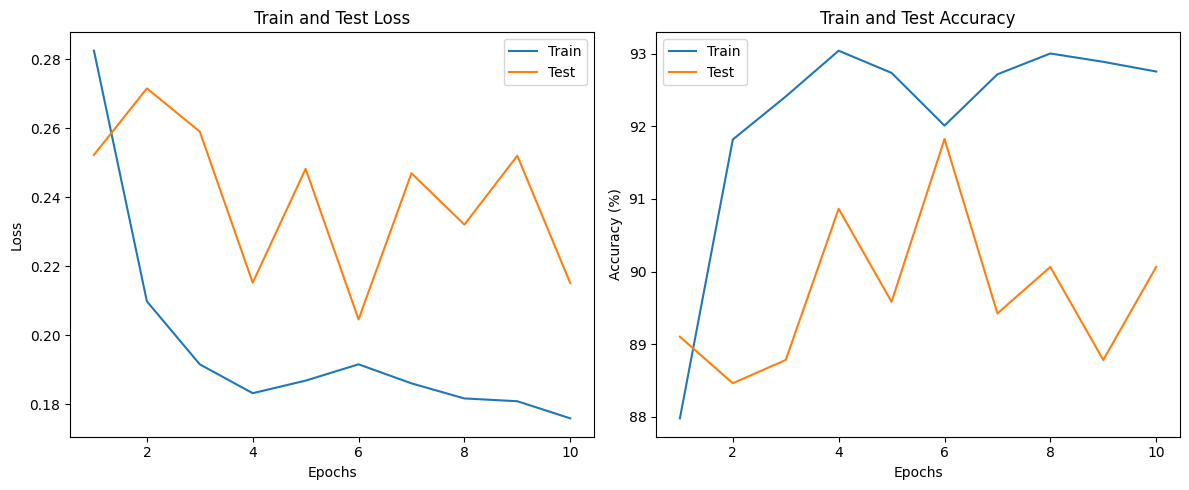

In [ ]:
model = VGG19Binary().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

# Lists to store loss and accuracy values for train and test data
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        total_train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * total_train_correct / total_train_samples
    train_loss /= len(train_dataloader.dataset)

    # Validation (Test data)
    model.eval()
    test_loss = 0.0
    total_test_correct = 0
    total_test_samples = 0

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test_samples += labels.size(0)
            total_test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * total_test_correct / total_test_samples
    test_loss /= len(test_dataloader.dataset)

    # Append loss and accuracy values to the lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Plot the loss and accuracy graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Test Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Train and Test Accuracy')

plt.tight_layout()
plt.show()